In [170]:
import os 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
%matplotlib inline
from segmentation_models_pytorch import utils as smpu
import seaborn as sns
from typing import List, Dict, Tuple, Union

## Конфигурация путей к данным

In [171]:
DATA_DIR = 'dataset/tiff'
PATHS = {
    'train': ('train', 'train_labels'),
    'val': ('val', 'val_labels'),
    'test': ('test', 'test_labels')
}


In [172]:
def setup_data_paths(base_dir: str, path_config: Dict[str, Tuple[str, str]]):
    """
    Создает пути к директориям с изображениями и масками.
    
    Args:
        base_dir: Базовая директория с данными
        path_config: Конфигурация поддиректорий в формате {тип: (дир_изображений, дир_масок)}
    
    Returns:
        Словарь с полными путями в формате {тип: (путь_к_изображениям, путь_к_маскам)}
    """
    return {
        data_type: (
            os.path.join(base_dir, img_dir),
            os.path.join(base_dir, mask_dir)
        ) for data_type, (img_dir, mask_dir) in path_config.items()
    }

# Создаем пути
data_paths = setup_data_paths(DATA_DIR, PATHS)
x_train_dir, y_train_dir = data_paths['train']
x_val_dir, y_val_dir = data_paths['val']
x_test_dir, y_test_dir = data_paths['test']

In [173]:
def load_class_info(csv_path: str, selected_classes: List[str]):
    """
    Загружает информацию о классах из CSV файла.
    
    Args:
        csv_path: Путь к CSV файлу с описанием классов
        selected_classes: Список классов для использования
    
    Returns:
        Кортеж (RGB значения выбранных классов, имена выбранных классов)
    """
    class_df = pd.read_csv(csv_path)
    
    # Проверка наличия необходимых колонок
    required_columns = ['name', 'r', 'g', 'b']
    if not all(col in class_df.columns for col in required_columns):
        raise ValueError(f"CSV файл должен содержать колонки: {required_columns}")
    
    # Приводим имена классов к нижнему регистру для сравнения
    class_names = class_df['name'].str.lower().tolist()
    class_rgb_values = class_df[['r', 'g', 'b']].values.tolist()
    
    # Проверка наличия запрошенных классов
    missing_classes = [cls for cls in selected_classes if cls.lower() not in class_names]
    if missing_classes:
        raise ValueError(f"Классы не найдены в CSV: {missing_classes}")
    
    # Получаем индексы выбранных классов
    selected_indices = [class_names.index(cls.lower()) for cls in selected_classes]
    
    return np.array(class_rgb_values)[selected_indices], selected_classes

# Загружаем информацию о классах
CLASS_CSV_PATH = "./dataset/label_class_dict.csv"
SELECT_CLASSES = ['background', 'road']

try:
    select_class_rgb_values, select_classes = load_class_info(CLASS_CSV_PATH, SELECT_CLASSES)
    print(f"Успешно загружены классы: {select_classes}")
    print(f"RGB значения: {select_class_rgb_values.tolist()}")
except Exception as e:
    print(f"Ошибка при загрузке информации о классах: {str(e)}")
    raise

Успешно загружены классы: ['background', 'road']
RGB значения: [[0, 0, 0], [255, 255, 255]]


## Функция для визуализации изображений

In [174]:
def visualize(**images):
    """
    Визуализирует несколько изображений в одном окне.
    
    Args:
        **images: пары имя=изображение для отображения (например, original_image=img)
    
    Example:
        visualize(
            original_image=img1,
            ground_truth=img2,
            prediction=img3
        )
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

## one-hot кодирование

In [175]:
def one_hot_encode(label: np.ndarray, 
                  label_values: List[Union[List[int], np.ndarray]]):
    """
    Конвертирует RGB маску в one-hot encoded маску.
    
    Args:
        label: RGB маска формы (H, W, 3)
        label_values: Список RGB значений классов
    
    Returns:
        One-hot encoded маска формы (H, W, num_classes)
    """   
    road_color = label_values[1]  # RGB для дороги
    road_mask = np.all(label == road_color, axis=-1).astype(np.float32)
    background_mask = 1 - road_mask
    
    return np.stack([background_mask, road_mask], axis=-1)

def reverse_one_hot(image: np.ndarray):
    """
    Конвертирует one-hot encoded маску обратно в классовые индексы.
    
    Args:
        image: One-hot encoded маска формы (H, W, num_classes)
    
    Returns:
        Маска с классовыми индексами формы (H, W)
    """
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image: np.ndarray, 
                           label_values: List[Union[List[int], np.ndarray]]):
    """
    Кодирует маску с классовыми индексами в RGB маску.
    
    Args:
        image: Маска с классовыми индексами формы (H, W)
        label_values: Список RGB значений классов
    
    Returns:
        RGB маска формы (H, W, 3)
    """
    colour_codes = np.array(label_values)
    return colour_codes[image.astype(np.uint8)]

## Аугментации

In [176]:
def get_training_augmentation():
    """
    Создаёт комплексный пайплайн аугментаций для обучающего набора данных.
    
    Основные группы аугментаций:
    1. Обрезка:
    - Случайное кадрирование до размера 256x256 пикселей
    
    2. Цветовые преобразования (применяются с вероятностью 75%):
    - Коррекция гаммы
    - Изменение яркости/контраста
    - CLAHE-эквализация
    - Настройка оттенка/насыщенности
    
    3. Геометрические преобразования (75% вероятность):
    - Отражения по горизонтали/вертикали
    - Повороты на 90°
    - Сдвиг, масштабирование и вращение
    - Эластичные деформации
    
    4. Перспективные искажения (50% вероятность):
    - Имитация изменения ракурса съёмки
    
    5. Размытия и шумы (50% вероятность):
    - Гауссово размытие
    - Гауссов шум
    - Имитация шумов ISO
    
    Все преобразования сохраняют соответствие между изображением и маской.
    Гарантируется, что выходные маски остаются валидными после преобразований.
    
    Returns:
        Albumentations Compose: Объект с последовательностью аугментаций,
                               применяемых к изображениям и маскам одновременно
    """
    train_transform = [
        # Базовые аугментации
        album.RandomCrop(height=256, width=256, always_apply=True),
        
        # Цветовые аугментации
        album.OneOf([
            album.RandomGamma(gamma_limit=(80, 120), p=0.5),
            album.RandomBrightnessContrast(
                brightness_limit=0.2, 
                contrast_limit=0.2, 
                brightness_by_max=True,
                p=0.5
            ),
            album.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
            album.HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=20,
                val_shift_limit=10,
                p=0.5
            )
        ], p=0.75),
        
        # Геометрические аугментации
        album.OneOf([
            album.HorizontalFlip(p=0.5),
            album.VerticalFlip(p=0.5),
            album.RandomRotate90(p=0.5),
            album.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.1,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5
            ),
            album.ElasticTransform(
                alpha=1,
                sigma=50,
                alpha_affine=50,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.25
            )
        ], p=0.75),
        
        # Аугментации перспективы
        album.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            pad_mode=cv2.BORDER_CONSTANT,
            p=0.5
        ),
        
        # Размытия и шумы
        album.OneOf([
            album.GaussianBlur(blur_limit=(3, 5), p=0.5),
            album.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            album.ISONoise(
                color_shift=(0.01, 0.05),
                intensity=(0.1, 0.5),
                p=0.5
            )
        ], p=0.5)
    ]
    
    return album.Compose(train_transform)


def get_validation_augmentation():
    """
    Создаёт пайплайн аугментации для валидационного/тестового набора данных.
    
    Применяет дополнение изображения до минимального размера 1536x1536.
    
    Returns:
        Albumentations Compose объект с трансформацией.
    """
    test_transform = [
        album.PadIfNeeded(
            min_height=1536,
            min_width=1536,
            always_apply=True,
            border_mode=cv2.BORDER_CONSTANT
        ),
        # Легкие цветовые аугментации для валидации
        album.RandomGamma(gamma_limit=(90, 110), p=0.3)
    ]
    
    return album.Compose(test_transform)


def to_tensor(x: np.ndarray, **kwargs):
    """
    Преобразует изображение из HWC в CHW формат и тип float32.
    
    Args:
        x: Изображение в формате (H, W, C)
    
    Returns:
        Изображение в формате (C, H, W), тип float32
    """
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """
    Создаёт пайплайн препроцессинга данных.
    
    Если указана функция препроцессинга, она применяется к изображению.
    Затем изображение и маска преобразуются в формат CHW и float32.
    
    Args:
        preprocessing_fn: Функция препроцессинга (например, нормализация)
    
    Returns:
        Albumentations Compose объект с трансформациями.
    """
    _transform = []

    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


## Визуализация метрик обучения

In [177]:
class RoadIoU(smp.utils.metrics.IoU):
    def __init__(self, threshold=0.5):
        super().__init__(threshold=threshold)
        
    def forward(self, y_pr, y_gt):
        # Берем только канал с дорогой (класс 1)
        y_pr = y_pr[:, 1:2, :, :]  # shape: [B, 1, H, W]
        y_gt = y_gt[:, 1:2, :, :]  # shape: [B, 1, H, W]
        
        return super().forward(y_pr, y_gt)

In [178]:
sns.set_style("whitegrid")
plt.style.use('ggplot')


def plot_training_metrics(train_logs_list, val_logs_list, save_path=None):
    """
    Визуализирует метрики обучения (Dice Loss и IoU Score) для тренировочного и валидационного наборов.
    
    Аргументы:
        train_logs_list (list[dict]): Список словарей с метриками на обучающем наборе.
        val_logs_list (list[dict]): Список словарей с метриками на валидационном наборе.
        save_path (str, optional): Путь для сохранения графика. Если None — график отобразится.
    """
    # Извлечение метрик
    train_loss = [epoch['dice_loss'] for epoch in train_logs_list]
    val_loss = [epoch['dice_loss'] for epoch in val_logs_list]
    
    train_iou = [epoch['iou_score'] for epoch in train_logs_list]
    val_iou = [epoch['iou_score'] for epoch in val_logs_list]
    
    epochs = list(range(1, len(train_logs_list) + 1))

    # Создание графиков
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # --- Dice Loss ---
    axes[0].plot(epochs, train_loss, label='Train Loss', marker='o')
    axes[0].plot(epochs, val_loss, label='Validation Loss', marker='x')
    axes[0].set_title('Dice Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # --- IoU Score ---
    axes[1].plot(epochs, train_iou, label='Train IoU', marker='o')
    axes[1].plot(epochs, val_iou, label='Validation IoU', marker='x')
    axes[1].set_title('IoU Score per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('IoU')
    axes[1].legend()

    plt.show()

In [179]:
class RoadsDataset(torch.utils.data.Dataset):
	"""
	Кастомный датасет для сегментации дорог. Загружает изображения и соответствующие маски,
	выполняет one-hot кодирование масок и применяет аугментации и препроцессинг, если указаны.

	Аргументы:
		images_dir (str): Путь к директории с изображениями.
		masks_dir (str): Путь к директории с масками.
		class_rgb_values (list[tuple]): Список RGB-значений классов для one-hot кодирования.
		augmentation (albumentations.Compose, optional): Аугментации, применяемые к изображениям и маскам.
		preprocessing (albumentations.Compose, optional): Препроцессинг.
	"""

	def __init__(self, images_dir, masks_dir, class_rgb_values=None,
				augmentation=None, preprocessing=None):
		self.image_paths = [os.path.join(images_dir, image_id)
							for image_id in sorted(os.listdir(images_dir))]
		self.mask_paths = [os.path.join(masks_dir, image_id)
							for image_id in sorted(os.listdir(masks_dir))]
		self.class_rgb_values = class_rgb_values
		self.augmentation = augmentation
		self.preprocessing = preprocessing

	def __getitem__(self, i):
		# Чтение изображения и маски, приведение к RGB
		image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
		mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

		# One-hot кодирование маски
		mask = one_hot_encode(mask, self.class_rgb_values).astype('float32')

		# Аугментации
		if self.augmentation:
			sample = self.augmentation(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']

		# Препроцессинг
		if self.preprocessing:
			sample = self.preprocessing(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']

		return image, mask

	def __len__(self):
		return len(self.image_paths)

## Инициализация UNET

In [180]:
# Параметры модели
ENCODER = 'resnet50'                 # Энкодер: ResNet-50
ENCODER_WEIGHTS = 'imagenet'         # Предобученные веса на ImageNet
CLASSES = select_classes             # Список целевых классов сегментации
ACTIVATION = 'sigmoid'               # Активация на выходе

# Инициализация модели UNet
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

# Функция препроцессинга изображений под выбранный энкодер
preprocessing_fn = smp.encoders.get_preprocessing_fn(
    encoder_name=ENCODER,
    pretrained=ENCODER_WEIGHTS
)

## Загрузка данных

In [181]:
# Создание тренировочного датасета с аугментацией и препроцессингом
train_dataset = RoadsDataset(
    images_dir=x_train_dir,
    masks_dir=y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Создание валидационного датасета с препроцессингом и минимальной аугментацией
val_dataset = RoadsDataset(
    images_dir=x_val_dir,
    masks_dir=y_val_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Загрузчики данных
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

/tmp/ipykernel_2045785/2441358301.py:38: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=256, width=256, always_apply=True),
/home/v.chernodolya/.local/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_2045785/2441358301.py:70: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  album.ElasticTransform(
/tmp/ipykernel_2045785/2441358301.py:80: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  album.Perspective(
/tmp/ipykernel_2045785/2441358301.py:90: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  album.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
/tmp/ipykernel_2045785/2441358301.py:112: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNe

/tmp/ipykernel_2045785/2441358301.py:38: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  album.RandomCrop(height=256, width=256, always_apply=True),
/tmp/ipykernel_2045785/2441358301.py:70: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  album.ElasticTransform(
/tmp/ipykernel_2045785/2441358301.py:80: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  album.Perspective(
/tmp/ipykernel_2045785/2441358301.py:90: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  album.GaussNoise(var_limit=(10.0, 50.0), p=0.5),


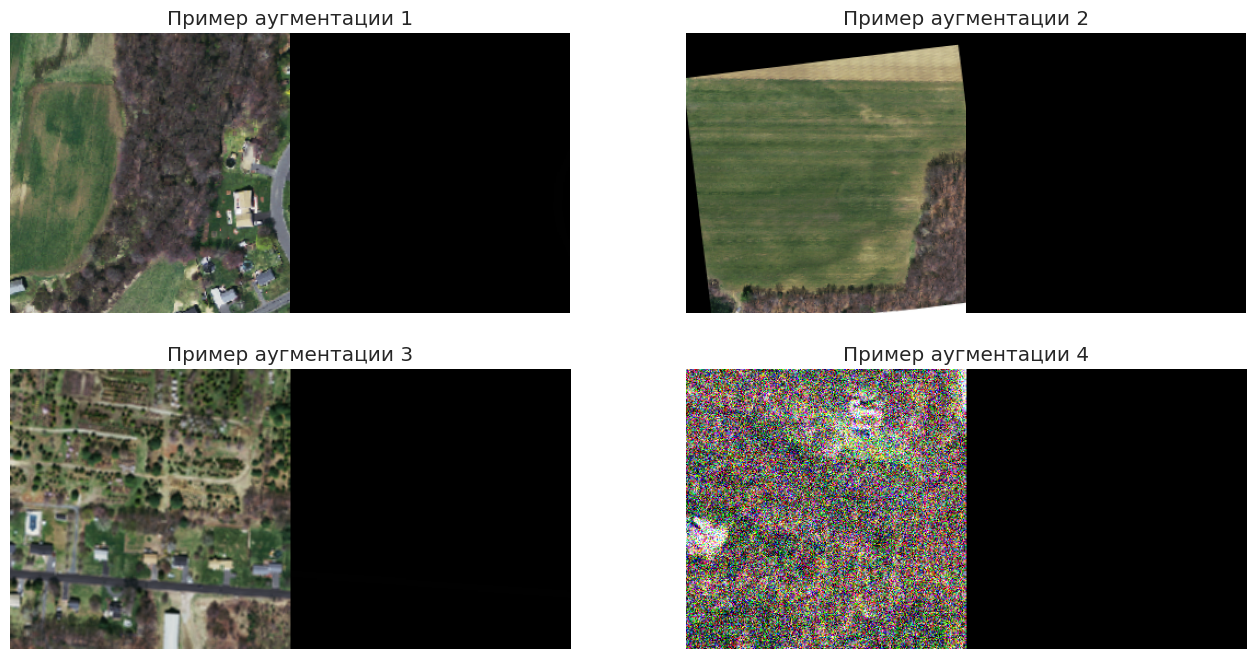

In [182]:
# Проверка новых аугментаций
sample_img = cv2.cvtColor(cv2.imread(train_dataset.image_paths[0]), cv2.COLOR_BGR2RGB)
sample_mask = cv2.cvtColor(cv2.imread(train_dataset.mask_paths[0]), cv2.COLOR_BGR2RGB)

aug = get_training_augmentation()

plt.figure(figsize=(16, 8))
for i in range(4):
    augmented = aug(image=sample_img, mask=sample_mask)
    plt.subplot(2, 2, i+1)
    plt.imshow(np.hstack([augmented['image'], 
                        cv2.cvtColor(augmented['mask']*255, cv2.COLOR_BGR2RGB)]))
    plt.title(f'Пример аугментации {i+1}')
    plt.axis('off')
plt.show()

## Подготовка к обучению

In [183]:
# Конфигурация
TRAINING = True
EPOCHS = 30
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {DEVICE}")

# 1. Инициализация моделей и режимов
reg_modes = {
    "No_regularization": {
        "model": smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS, 
                         classes=len(CLASSES)),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5),
        "loss_func": smpu.losses.DiceLoss()
    },
    "L2_weight_decay": {
        "model": smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS,
                         classes=len(CLASSES)),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5, weight_decay=1e-4),
        "loss_func": smpu.losses.DiceLoss()
    },
    "L1_penalty_to_1": {
        "model": smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS,
                         classes=len(CLASSES)),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5),
        "loss_func": lambda pred, gt: (
            smpu.losses.DiceLoss()(pred, gt) + 
            0.01 * sum(torch.abs(p - 1).sum() for p in model.parameters())
        )
    }
}

Используемое устройство: cuda:1


## Обучение

In [184]:
# Обучение всех режимов
results = {}
for reg_name, config in reg_modes.items():
    print(f"\n=== Training: {reg_name} ===")
    
    model = config["model"].to(DEVICE)
    optimizer = config["optimizer"](model)
    loss_func = config["loss_func"]
    
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=1, T_mult=2, eta_min=5e-5
    )

    # Инициализация эпох с кастомным loss
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss_func,
        metrics=[RoadIoU(threshold=0.5), smpu.metrics.Fscore(threshold=0.5)],
        optimizer=optimizer,
        device=DEVICE,
        verbose=True
    )
    
    val_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=smpu.losses.DiceLoss(),  # Для валидации используем только основной loss
        metrics=[RoadIoU(threshold=0.5), smpu.metrics.Fscore(threshold=0.5)],
        device=DEVICE,
        verbose=True
    )

    train_logs, val_logs = [], []
    best_iou = 0
    
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        
        # Обучение с кастомным loss
        train_log = train_epoch.run(train_loader)
        
        # Валидация (без регуляризации)
        val_log = val_epoch.run(val_loader)
        
        train_logs.append(train_log)
        val_logs.append(val_log)
        
        # Сохранение лучшей модели
        if val_log['iou_score'] > best_iou:
            best_iou = val_log['iou_score']
            torch.save(model.state_dict(), f'best_{reg_name}.pth')
            print(f'Model saved with IoU: {best_iou:.4f}')
    
    results[reg_name] = {
        'train': train_logs,
        'val': val_logs
    }

# Визуализация результатов
plt.figure(figsize=(15, 6))

# График IoU
plt.subplot(1, 2, 1)
for reg_name, data in results.items():
    plt.plot([x['iou_score'] for x in data['val']], label=reg_name)
plt.title('Validation IoU Comparison')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

# График Loss
plt.subplot(1, 2, 2)
for reg_name, data in results.items():
    plt.plot([x['dice_loss'] for x in data['val']], label=reg_name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()

plt.tight_layout()
plt.savefig('regularization_comparison.png')
plt.show()

# Анализ весов
for reg_name in reg_modes:
    model = reg_modes[reg_name]["model"].load_state_dict(torch.load(f'best_{reg_name}.pth'))
    weights = torch.cat([p.flatten() for p in model.parameters()]).cpu().detach().numpy()
    
    plt.hist(weights, bins=50, alpha=0.5, label=reg_name, range=(-2, 2))

plt.title('Weight Distribution Comparison')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('weight_distribution.png')
plt.show()


=== Training: No_regularization ===
Epoch 1/30
valid: 100%|██████████| 14/14 [00:04<00:00,  3.44it/s, dice_loss - -0.4205, iou_score - 1.386e-05, fscore - 0.4138]
Model saved with IoU: 0.0000
Epoch 2/30
valid: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s, dice_loss - -0.5893, iou_score - 2.728e-05, fscore - 0.3002]
Model saved with IoU: 0.0000
Epoch 3/30
valid: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s, dice_loss - -0.3606, iou_score - 0.0002247, fscore - 0.4338]
Model saved with IoU: 0.0002
Epoch 4/30
valid: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s, dice_loss - -0.4218, iou_score - 2.963e-05, fscore - 0.2598]
Epoch 5/30
valid: 100%|██████████| 14/14 [00:04<00:00,  3.48it/s, dice_loss - -0.9616, iou_score - 0.00016, fscore - 0.483]     
Epoch 6/30
valid: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s, dice_loss - -29.59, iou_score - 0.001221, fscore - 0.4903]
Model saved with IoU: 0.0012
Epoch 7/30
valid: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s, dice_loss - 1.063, 

KeyboardInterrupt: 

Используемое устройство: cuda:1



=== Режим: No_reg ===
Epoch 1/30
Train loss: 0.3748 | Val IoU: 0.1139
Модель сохранена с IoU: 0.1139
Epoch 2/30
Train loss: 0.2742 | Val IoU: 0.2871
Модель сохранена с IoU: 0.2871
Epoch 3/30
Train loss: 0.2259 | Val IoU: 0.3245
Модель сохранена с IoU: 0.3245
Epoch 4/30
Train loss: 0.1871 | Val IoU: 0.3263
Модель сохранена с IoU: 0.3263
Epoch 5/30
Train loss: 0.1525 | Val IoU: 0.3195
Epoch 6/30
Train loss: 0.1279 | Val IoU: 0.3740
Модель сохранена с IoU: 0.3740
Epoch 7/30
Train loss: 0.1111 | Val IoU: 0.3872
Модель сохранена с IoU: 0.3872
Epoch 8/30
Train loss: 0.0968 | Val IoU: 0.4545
Модель сохранена с IoU: 0.4545
Epoch 9/30
Train loss: 0.0842 | Val IoU: 0.4782
Модель сохранена с IoU: 0.4782
Epoch 10/30
Train loss: 0.0752 | Val IoU: 0.4923
Модель сохранена с IoU: 0.4923
Epoch 11/30
Train loss: 0.0685 | Val IoU: 0.4662
Epoch 12/30
Train loss: 0.0632 | Val IoU: 0.5234
Модель сохранена с IoU: 0.5234
Epoch 13/30
Train loss: 0.0592 | Val IoU: 0.4906
Epoch 14/30
Train loss: 0.0567 | Val Io

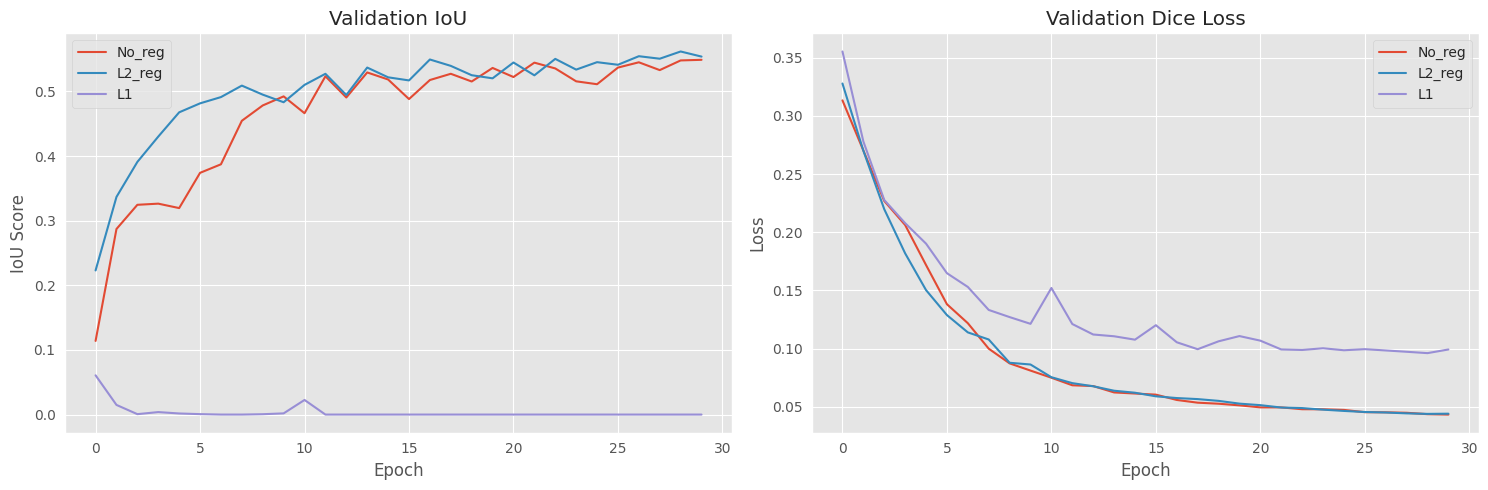

In [189]:
from copy import deepcopy
# Конфигурация
TRAINING = True
EPOCHS = 30
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {DEVICE}")

# Инициализация базовой модели
base_model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION
)

# Регуляризационные режимы
reg_modes = {
    "No_reg": {
        "model": deepcopy(base_model).to(DEVICE),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5),
        "loss_func": smpu.losses.DiceLoss()
    },
    "L2_reg": {
        "model": deepcopy(base_model).to(DEVICE),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5, weight_decay=1e-4),
        "loss_func": smpu.losses.DiceLoss()
    },
    "L1": {
        "model": deepcopy(base_model).to(DEVICE),
        "optimizer": lambda m: torch.optim.Adam(m.parameters(), lr=8e-5),
        "loss_func": lambda pred, gt, model: (
            smpu.losses.DiceLoss()(pred, gt) + 
            0.001 * sum(torch.abs(p).sum() for p in model.parameters()))
    }
}

# Метрики
iou_metric = RoadIoU(threshold=0.5)
fscore_metric = smpu.metrics.Fscore(threshold=0.5)

# Обучение
results = {}
for reg_name, config in reg_modes.items():
    print(f"\n=== Режим: {reg_name} ===")
    
    model = config["model"]
    optimizer = config["optimizer"](model)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=1, T_mult=2, eta_min=5e-5
    )

    train_logs, val_logs = [], []
    best_iou = 0

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        
        # Обучение
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()

            pred = model(x)
            if reg_name == "L1":
                loss = config["loss_func"](pred, y, model)
            else:
                loss = config["loss_func"](pred, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        # Валидация
        model.eval()
        val_metrics = {'dice_loss': 0, 'iou_score': 0, 'fscore': 0}
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x)

                val_metrics['dice_loss'] += smpu.losses.DiceLoss()(pred, y).item()
                val_metrics['iou_score'] += iou_metric(pred, y).item()
                val_metrics['fscore'] += fscore_metric(pred, y).item()

        # Усреднение метрик
        for k in val_metrics:
            val_metrics[k] /= len(val_loader)

        avg_train_loss = total_loss / len(train_loader)
        train_logs.append({'dice_loss': avg_train_loss, **val_metrics})
        val_logs.append(val_metrics)

        print(f"Train loss: {avg_train_loss:.4f} | Val IoU: {val_metrics['iou_score']:.4f}")

        # Сохранение модели с лучшим IoU
        if val_metrics['iou_score'] > best_iou:
            best_iou = val_metrics['iou_score']
            torch.save(model.state_dict(), f'best_{reg_name}.pth')
            print(f"Модель сохранена с IoU: {best_iou:.4f}")

    results[reg_name] = {
        'train': train_logs,
        'val': val_logs
    }

# Визуализация
plt.figure(figsize=(15, 5))

# IoU-график
plt.subplot(1, 2, 1)
for reg_name, data in results.items():
    plt.plot([x['iou_score'] for x in data['val']], label=reg_name)
plt.title('Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

# Dice Loss-график
plt.subplot(1, 2, 2)
for reg_name, data in results.items():
    plt.plot([x['dice_loss'] for x in data['val']], label=reg_name)
plt.title('Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('comparison.png')
plt.show()

## Тестирование и визуализация

In [190]:
# Создание тестового датасета и загрузчика данных
test_dataset = RoadsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Создание датасета для визуализации
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# Функция для обрезки изображения (если оно больше целевого размера)
def crop_image(image, target_image_dims=[1500,1500,3]):
    """
    Обрезает изображение, если оно больше целевого размера, чтобы оно соответствовало
    целевым размерам. Если изображение меньше, возвращает его как есть.
    """
    target_size = target_image_dims[0]
    image_size = image.shape[0]
    padding = (image_size - target_size) // 2

    if padding < 0:
        return image  # Если изображение меньше целевого размера, возвращаем его без изменений

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :
    ]

# Папка для предсказаний
preds_folder = 'predictions/'
if not os.path.exists(preds_folder):
    os.makedirs(preds_folder)


/tmp/ipykernel_2045785/2441358301.py:112: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  album.PadIfNeeded(


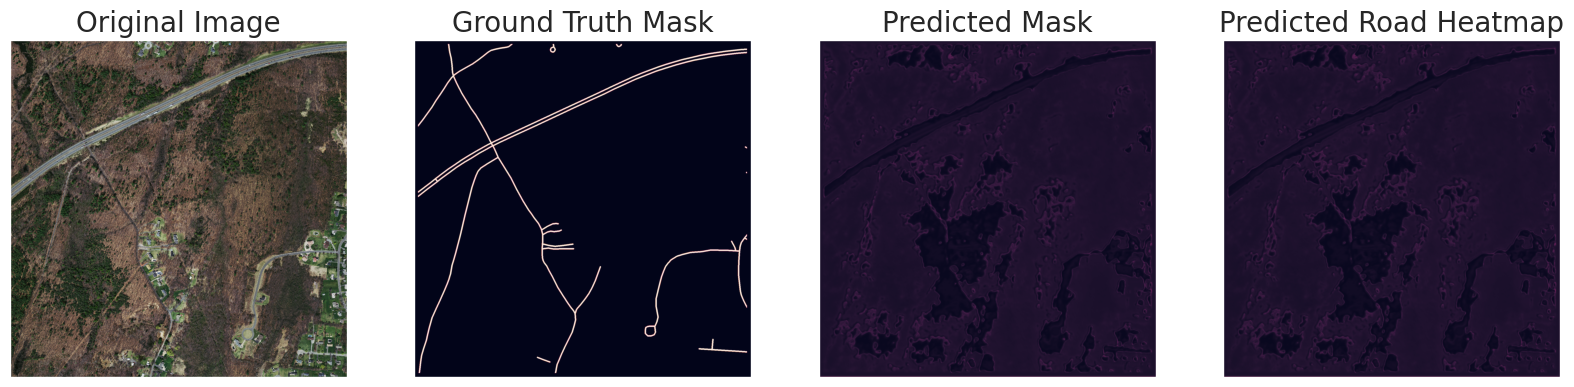

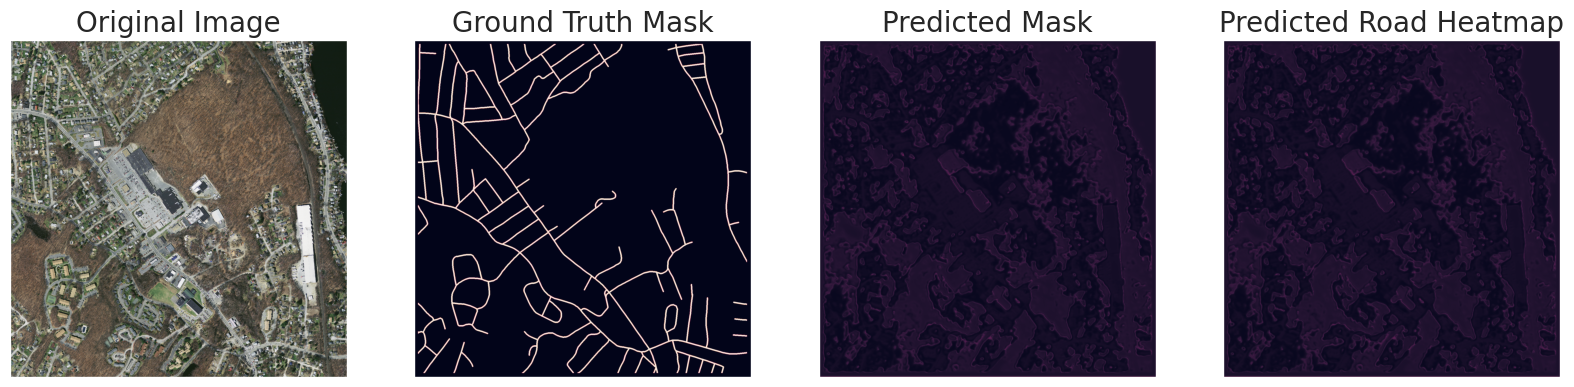

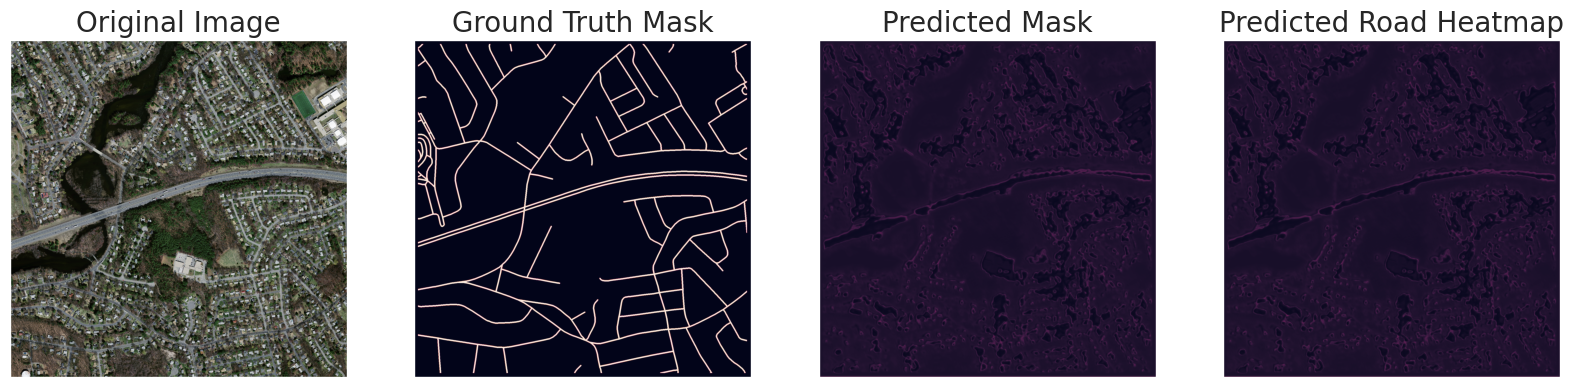

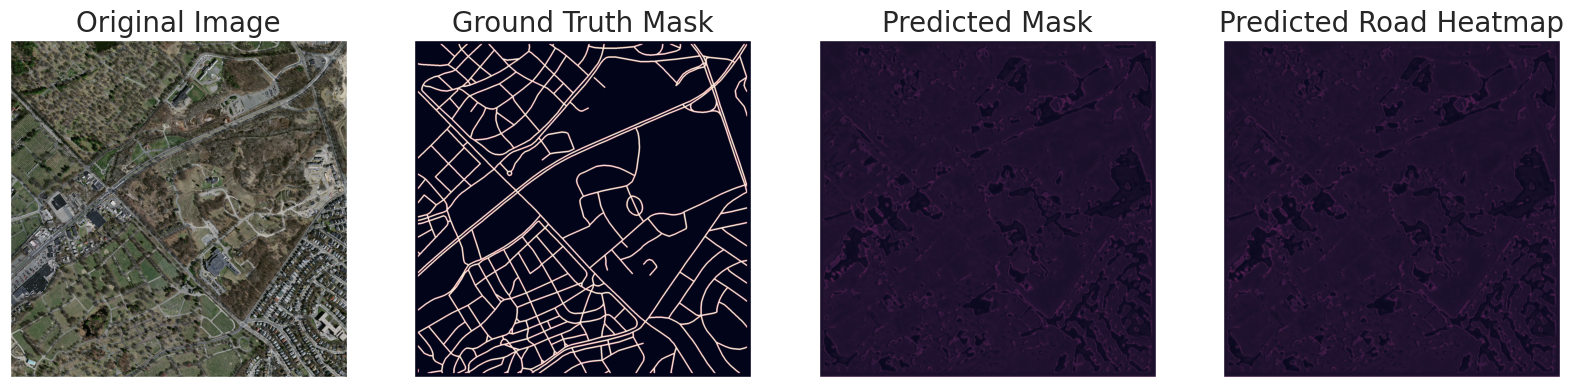

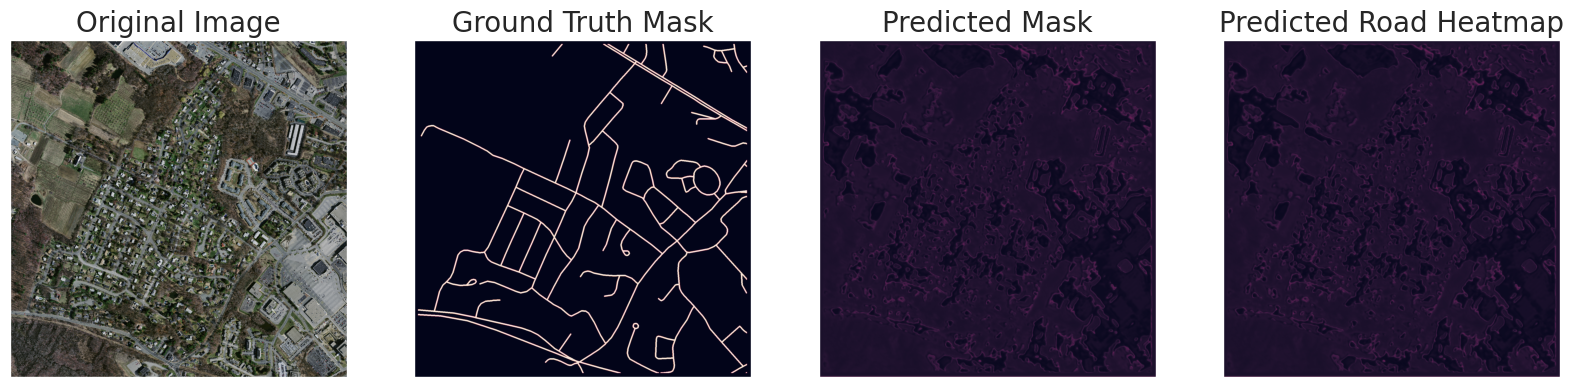

In [191]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    
    # Преобразование изображения в тензор
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0).float()
    
    # Предсказание маски
    with torch.no_grad():
        pred_mask = model(x_tensor)
    
    if idx % 10 == 0:
        # Получаем предсказание только для класса 'road'
        pred_road = pred_mask.squeeze()[1].cpu().numpy()  # shape: [H, W]
        
        # Получаем GT маску дороги
        gt_road = gt_mask[1]  # shape: [H, W]
        
        # Приводим все изображения к одинаковому размеру (1500x1500)
        target_size = (1500, 1500)
        
        # Масштабируем предсказание до 1500x1500
        pred_road = cv2.resize(pred_road, target_size)
        
        # Масштабируем GT маску до 1500x1500
        gt_road = cv2.resize(gt_road, target_size)
        
        # Создаем цветные версии для визуализации
        pred_visual = np.zeros((*target_size, 3), dtype=np.uint8)
        pred_visual[pred_road > 0.5] = [255, 255, 255]  # Белый цвет для дороги
        
        gt_visual = np.zeros((*target_size, 3), dtype=np.uint8)
        gt_visual[gt_road > 0.5] = [255, 255, 255]  # Белый цвет для дороги
        
        # Масштабируем оригинальное изображение до 1500x1500
        image_vis = cv2.resize(image_vis, target_size)
        
        # Сохраняем результат
        cv2.imwrite(os.path.join(preds_folder, f"sample_pred_{idx}.png"), 
                   np.hstack([image_vis, gt_visual, pred_visual])[:, :, ::-1])
        
        # Визуализация
        visualize(
            original_image=image_vis,
            ground_truth_mask=gt_road,
            predicted_mask=pred_road,
            predicted_road_heatmap=pred_road
        )